In [ ]:
import os
import getpass
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import MultiLineString, Point, LineString
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
import sys
sys.setrecursionlimit(2000)

## Network



### Graph
In this section, we have defined three data structures to store the data, which are adjacency list, adjacency matrix, and edge list.

In [ ]:
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.pos = (x, y)
        self.visited = False

# Graph implemented by adjacency list
class Graph:
    def __init__(self):
        # Initialize adjacency list and node dictionary
        self.adj_list = {}  # Adjacency list to store neighbors of each node
        self.nodes = {}     # Dictionary to store additional information about each node

    def add_edge(self, v, w, length):
        # Add an edge between vertices v and w with a given length
        self.adj_list.setdefault(v, []).append((w, length))  # Add w to the list of neighbors of v
        self.adj_list.setdefault(w, []).append((v, length))  # Add v to the list of neighbors of w

    def add_node(self, node_idx, node):
        # Add a node with index node_idx and additional information node
        self.nodes[node_idx] = node

    def get_node(self, node_idx):
        # Get additional information about a node given its index
        return self.nodes[node_idx]

    def get_edge_length(self, v, w):
        # Get the length of the edge between vertices v and w
        for node, length in self.adj_list[v]:
            if node == w:
                return length
        return None  # If there is no edge between v and w, return None

    def adj(self, v):
        # Get the list of adjacent vertices to vertex v
        return self.adj_list[v]


# Graph implemented by adjacency matrix
class Graph_matrix:
    def __init__(self):
        self.dis_matrix = np.zeros((4965, 4956))  # Initialize the distance matrix with zeros
        self.nodes = {}  # Dictionary to store additional information about each node

    def add_edge(self, v, w, length):
        # Add an edge between vertices v and w with a given length
        self.dis_matrix[v][w] = length
        self.dis_matrix[w][v] = length

    def add_node(self, node_idx, node):
        # Add a node with index node_idx and additional information node
        self.nodes[node_idx] = node

    def get_node(self, node_idx):
        # Get additional information about a node given its index
        return self.nodes[node_idx]

    def adj(self, v):
        # Get the adjacency list for the vertex v
        return self.dis_matrix[v]

# Graph from Edge List
class GraphFromEdgeList:
    def __init__(self):
        self.edges = []  # List to store edges
        self.nodes = set()  # Set to store unique nodes

    def add_edge(self, source, target, length):
        # Add an edge with source, target, and length
        self.edges.append((source, target, length))
        self.nodes.add(source)  # Add source to the set of nodes
        self.nodes.add(target)  # Add target to the set of nodes


To read a .gpkg file and generate the corresponding graph, two functions are defined here: preprocess_gdf and preprocess_gdf_to_edge_list, to process the original data. The input data format to these two functions needs to be in the GeoDataFrame format.

In [ ]:
def preprocess_gdf(gdf, graph=Graph()):
    # Initialize an empty dictionary to store points and their corresponding node indices
    points_dict = {}
    node_index = 0

    # Iterate over each row in the GeoDataFrame
    for idx, row in gdf.iterrows():
        # Extract multilines geometry from the row
        multilines = row['geometry']

        # Iterate over each individual line segment in the multilines
        for points in multilines.geoms:
            xy = points.xy

            # If the line segment has more than or equal to 2 points, simplify it to a line
            if len(xy[0]) >= 2:
                x1, y1 = xy[0][0], xy[1][0]  # Start point
                x2, y2 = xy[0][-1], xy[1][-1]  # End point

                # Check if the start point already exists in the points dictionary
                v = points_dict.get((x1, y1))
                if v is None:
                    # If not, assign a new node index and add the start point as a node to the graph
                    v = node_index
                    node = Node(x1, y1)
                    graph.add_node(v, node)
                    points_dict[(x1, y1)] = node_index
                    node_index += 1

                # Check if the end point already exists in the points dictionary
                w = points_dict.get((x2, y2))
                if w is None:
                    # If not, assign a new node index and add the end point as a node to the graph
                    w = node_index
                    node = Node(x2, y2)
                    graph.add_node(w, node)
                    points_dict[(x2, y2)] = w
                    node_index += 1

                # Add the length of the line segment as an edge between the start and end points
                length = row['SHAPE_Length']
                graph.add_edge(v, w, length)

    return graph


In [ ]:
def preprocess_gdf_to_edge_list(gdf):
    # Initialize an empty graph represented by an edge list
    edge_list_graph = GraphFromEdgeList()

    # Iterate over each row in the GeoDataFrame
    for idx, row in gdf.iterrows():
        # Extract multilines geometry from the row
        multilines = row['geometry']

        # Iterate over each individual line segment in the multilines
        for points in multilines.geoms:
            xy = points.xy

            # If the line segment has more than or equal to 2 points, simplify it to a line
            if len(xy[0]) >= 2:
                x1, y1 = xy[0][0], xy[1][0]  # Start point
                x2, y2 = xy[0][-1], xy[1][-1]  # End point

                # Add an edge between the start and end points with the length of the line segment
                edge_list_graph.add_edge((x1, y1), (x2, y2), row['SHAPE_Length'])

    return edge_list_graph


Based on runtime analysis, storing the graph in the form of an adjacency list is the most efficient. Therefore,graphs used in next steps will be stored in the adjacency list.

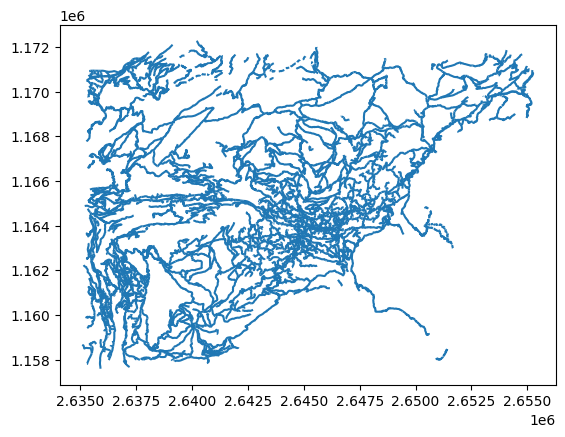

In [ ]:
gdf = gpd.read_file('/content/drive/MyDrive/Roads_small.gpkg')
old_graph = Graph()
old_graph = preprocess_gdf(gdf,old_graph)
fig, ax = plt.subplots()
gdf.plot(ax=ax)
plt.show()

### Clean graph
From the map above, it can be observed that there are many small paths not connected to the main graph. Therefore, the DFS algorithm was used to clean the graph and obtain the primary graph.

In [ ]:
class dfs:
    @staticmethod
    def find_connected_components(graph):
        # Initialize a set to keep track of visited nodes
        visited = set()
        # Initialize a list to store the connected components
        components = []

        # Iterate over each node in the graph
        for node in range(len(graph.nodes)):
            # If the node has not been visited
            if node not in visited:
                # Initialize a new component set
                component = set()
                # Perform a depth-first search to find all nodes in this component
                dfs.dfs_component(graph, node, component)
                # Add the discovered component to the list of components
                components.append(component)
                # Mark all nodes in this component as visited
                visited.update(component)

        # Return the list of connected components
        return components

    @staticmethod
    def dfs_component(graph, node, component):
        # Add the current node to the component
        component.add(node)

        # Iterate over all neighbors of the current node
        for neighbor in graph.adj_list[node]:
            # If the neighbor is not already in the component
            if neighbor[0] not in component:
                # Recursively perform DFS on the neighbor
                dfs.dfs_component(graph, neighbor[0], component)
    @staticmethod
    def get_largest_component(components):
        # Return the largest component by length
        return max(components, key=len)
    @staticmethod
    def filter_graph(components, largest_component, gdf):
        # Initialize a list to store nodes to remove
        nodes_to_remove = []

        # Iterate over each subgraph in the components list
        for subgraph in components:
            # If the subgraph is not the largest component
            if subgraph != largest_component:
                # Add the subgraph to the nodes to remove list
                nodes_to_remove.append(subgraph)

        # Flatten the list of nodes to remove
        delete_list = [item for subset in nodes_to_remove for item in subset]

        # Iterate over each row in the GeoDataFrame
        for idx, row in gdf.iterrows():
            # Get the geometry (MultiLineString) of the current row
            multilines = row['geometry']
            # Iterate over each line (LineString) in the MultiLineString
            for points in multilines.geoms:
                # Get the start and end points of the line
                xy = points.xy
                x1, y1 = xy[0][0], xy[1][0]
                x2, y2 = xy[0][-1], xy[1][-1]
                # Check if either end of the line is a node in the delete list
                for node in delete_list:
                    if (x1, y1) == graph.get_node(node).pos or (x2, y2) == graph.get_node(node).pos:
                        # If so, drop the row from the GeoDataFrame
                        gdf.drop(idx, inplace=True)
                        break

        # Reset the index of the GeoDataFrame after dropping rows
        gdf.reset_index(drop=True, inplace=True)
        # Define the output file path
        output_file = '/content/drive/MyDrive/clean_graph.gpkg'
        # Save the filtered GeoDataFrame to a file in GeoPackage format
        gdf.to_file(output_file, driver='GPKG')
        print("file has been saved")




In [ ]:

# find connected components
components = dfs.find_connected_components(old_graph)
print("connected components:", components)

# find largest component
largest_component = dfs.get_largest_component(components)
print("largest connected components:", largest_component)

dfs.filter_graph(components, largest_component, gdf)

connected components: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

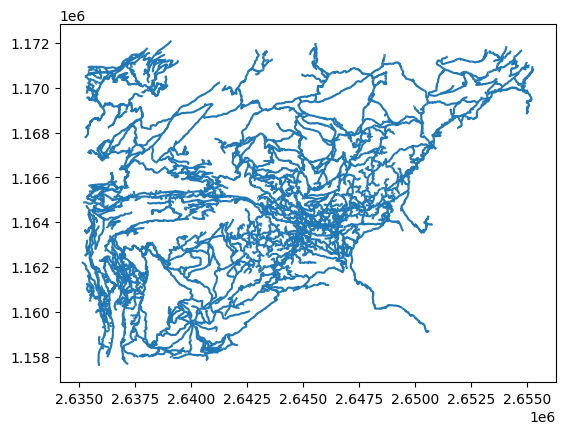

In [ ]:
clean_gdf = gpd.read_file('/content/drive/MyDrive/clean_graph.gpkg')
clean_graph = Graph()
clean_graph = preprocess_gdf(gdf,clean_graph)
fig, ax = plt.subplots()
clean_gdf.plot(ax=ax)
plt.show()

After cleaning the graph using the DFS algorithm, it can be seen that the small, fragmented paths not connected to the main graph have been removed.

### Merge graph
In the new graph, there are some nodes that are only connected to two other nodes. These nodes can be used to merge the original two multiline strings into one. By removing these nodes from the node list, we can reduce the number of nodes that need to be considered in the shortest path algorithm, thereby improving runtime efficiency and saving storage space.

In [ ]:
class MergeMitnodes:

    def visit_node(graph, mitnodes, node_idx):
        """
        Recursively visit nodes and collect nodes connected to the given node.

        Parameters:
        graph (Graph): The graph object.
        mitnodes (set): A set of nodes to be visited.
        node_idx (int): The current node index being visited.

        Returns:
        None
        """
        if node_idx not in mitnodes:
            return
        mitnodes.remove(node_idx)
        pointslist.append(node_idx)

        for edge in graph.adj(node_idx):
            if edge[0] not in pointslist:  # Add this check to prevent revisiting nodes
                pointslist.append(edge[0])
                MergeMitnodes.visit_node(graph, mitnodes, edge[0])

    def find_multilinestring(graph, node1, node2, gdf):
        """
        Find the multilinestring between two nodes in the graph.

        Parameters:
        graph (Graph): The graph object.
        node1 (int): The starting node index.
        node2 (int): The ending node index.
        gdf (GeoDataFrame): The GeoDataFrame containing the geometries.

        Returns:
        tuple: The multilinestring, its index in the GeoDataFrame, and its length.
        """
        for idx, row in gdf.iterrows():
            multilines = row['geometry']
            length = row['SHAPE_Length']
            for points in multilines.geoms:
                xy = points.xy
                # Check if the start and end points of the multilinestring match the positions of node1 and node2
                if ((graph.get_node(node1).pos == (xy[0][0], xy[1][0]) or graph.get_node(node1).pos == (xy[0][-1], xy[1][-1])) and
                    (graph.get_node(node2).pos == (xy[0][0], xy[1][0]) or graph.get_node(node2).pos == (xy[0][-1], xy[1][-1]))):
                    return multilines, idx, length
        return None, None, None

    def merge_multilinestrings(geometries):
        """
        Merge multiple multilinestrings into a single multilinestring.

        Parameters:
        geometries (list): A list of multilinestring geometries to be merged.

        Returns:
        MultiLineString: The merged multilinestring.
        """
        # Start with the first geometry
        geom1 = geometries.pop(0)

        while len(geometries) > 0:
            found_connection = False  # Flag to indicate whether a connected multilinestring was found

            # Attempt to find a multilinestring among the remaining ones that connects to the start or end of the current one
            for m, geom2 in enumerate(geometries):
                for line1, line2 in zip(geom1.geoms, geom2.geoms):
                    startpoint1 = line1.xy[0][0], line1.xy[1][0]
                    startpoint2 = line2.xy[0][0], line2.xy[1][0]
                    endpoint1 = line1.xy[0][-1], line1.xy[1][-1]
                    endpoint2 = line2.xy[0][-1], line2.xy[1][-1]
                    pointslist = []

                    if startpoint1 == startpoint2:
                        for i in range(1, len(line2.xy[0])):
                            pointslist.append(Point(line2.xy[0][-i], line2.xy[1][-i]))
                        for i in range(len(line1.xy[0])):
                            pointslist.append(Point(line1.xy[0][i], line1.xy[1][i]))
                        linestring = LineString(pointslist)
                        multilinestring = MultiLineString([linestring])
                        geom1 = multilinestring
                        geometries.pop(m)
                        found_connection = True
                        break
                    elif startpoint1 == endpoint2:
                        for i in range(len(line2.xy[0])):
                            pointslist.append(Point(line2.xy[0][i], line2.xy[1][i]))
                        for i in range(1, len(line1.xy[0])):
                            pointslist.append(Point(line1.xy[0][i], line1.xy[1][i]))
                        linestring = LineString(pointslist)
                        multilinestring = MultiLineString([linestring])
                        geom1 = multilinestring
                        geometries.pop(m)
                        found_connection = True
                        break
                    elif endpoint1 == startpoint2:
                        for i in range(len(line1.xy[0])):
                            pointslist.append(Point(line1.xy[0][i], line1.xy[1][i]))
                        for i in range(1, len(line2.xy[0])):
                            pointslist.append(Point(line2.xy[0][i], line2.xy[1][i]))
                        linestring = LineString(pointslist)
                        multilinestring = MultiLineString([linestring])
                        geom1 = multilinestring
                        geometries.pop(m)
                        found_connection = True
                        break
                    elif endpoint1 == endpoint2:
                        for i in range(len(line1.xy[0])):
                            pointslist.append(Point(line1.xy[0][i], line1.xy[1][i]))
                        for i in range(2, len(line2.xy[0]) + 1):
                            pointslist.append(Point(line2.xy[0][-i], line2.xy[1][-i]))
                        linestring = LineString(pointslist)
                        multilinestring = MultiLineString([linestring])
                        geom1 = multilinestring
                        geometries.pop(m)
                        found_connection = True
                        break

            if not found_connection:
                break

        return geom1


This part codes first identifies nodes with exactly two connections, then iterates through these "mitnodes" to collect connected nodes. For each pair of connected nodes, it locates the corresponding multilinestring in the dataset and merges them into a single multilinestring. The resulting merged multilinestrings are stored along with their lengths. Additionally, it saves the indices of deleted multilinestrings to a CSV file for future reference. After processing, it creates a new GeoDataFrame containing the merged geometries and saves it to a GeoPackage file. Finally, it removes the deleted rows from the original GeoDataFrame, combines it with the cleaned data, and saves the final result to another GeoPackage file.

Due to the extensive runtime required for merging multiline strings, this section of the code won't be executed.

In [ ]:
'''
# Initialize lists to store geometries, lengths, and indices of lines to delete
geom = []
lengths = []
delete_index = []

# Identify nodes that have exactly two connections (mitnodes)
mitnodes = [node_idx for node_idx, edges in graph.adj.items() if len(edges) == 2]

# Process each mitnode
for node_idx in tqdm(mitnodes, desc="processing"):
    pointslist = []
    # Visit and collect all connected nodes
    MergeMitnodes.visit_node(graph, mitnodes, node_idx)
    pointslist = list(set(pointslist))
    print(pointslist)
    geometries = []

    lines_length = []

    # Find multilinestrings between each pair of points in pointslist
    for i in range(len(pointslist)):
        for j in range(i + 1, len(pointslist)):
            node1 = pointslist[i]
            node2 = pointslist[j]
            multilinestring, idx, length = MergeMitnodes.find_multilinestring(graph, node1, node2, gdf)
            if multilinestring is not None:
                geometries.append(multilinestring)
                delete_index.append(idx)
                lines_length.append(length)

    # Calculate the total length of the merged lines
    total_length = sum(lines_length)
    lengths.append(total_length)
    print(len(geometries))
    # Merge all found multilinestrings into one
    merged_multilinestring = MergeMitnodes.merge_multilinestrings(geometries)
    print(merged_multilinestring)
    geom.append(merged_multilinestring)

# Create a new GeoDataFrame with the merged geometries
gdf = gpd.GeoDataFrame(geometry=geom, crs='EPSG:2056')
gdf['SHAPE_Length'] = lengths

# Save the new GeoDataFrame to a GeoPackage file
output_file = '/content/drive/MyDrive/merged_graph.gpkg'
gdf.to_file(output_file, driver='GPKG')
print(f"GeoPackage file has already been saved to: {output_file}")

# Save the indices of deleted lines to a CSV file
delete_index_file = '/content/drive/MyDrive/delete_index.csv'
with open(delete_index_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for index in delete_index:
        writer.writerow([index])
print(f"Delete index has been saved to: {delete_index_file}")
'''


In [1]:
'''
# Read the delete indices from the CSV file
to_delete = pd.read_csv("/content/drive/MyDrive/delete_index.csv")
input_file = '/content/drive/MyDrive/merged_graph.gpkg'
combined_gdf = gpd.read_file(input_file)

# Get the list of row indices to delete
to_delete_list = to_delete.iloc[:, 0].tolist()

# Drop the rows in gdf whose indices are in to_delete_list
gdf.drop(to_delete_list, inplace=True)
gdf.reset_index(drop=True, inplace=True)

# Keep only the 'geometry' and 'SHAPE_Length' columns in gdf
gdf = gdf[['SHAPE_Length','geometry']]
combined_gdf.rename(columns={'length': 'SHAPE_Length'}, inplace=True)
new_gdf = pd.concat([gdf.reset_index(drop=True), combined_gdf.reset_index(drop=True)], axis=0, ignore_index=True)

# Save the final cleaned and combined GeoDataFrame to a GeoPackage file
output_file = '/content/drive/MyDrive/final_clean_combined.gpkg'
new_gdf.to_file(output_file, driver='GPKG')
new_gdf.reset_index(drop=True, inplace=True)
print(f"GeoPackage file has been saved to: {output_file}")
'''

'\n# Read the delete indices from the CSV file\nto_delete = pd.read_csv("/content/drive/MyDrive/delete_index.csv")\ninput_file = \'/content/drive/MyDrive/merged_graph.gpkg\'\ncombined_gdf = gpd.read_file(input_file)\n\n# Get the list of row indices to delete\nto_delete_list = to_delete.iloc[:, 0].tolist()\n\n# Drop the rows in gdf whose indices are in to_delete_list\ngdf.drop(to_delete_list, inplace=True)\ngdf.reset_index(drop=True, inplace=True)\n\n# Keep only the \'geometry\' and \'SHAPE_Length\' columns in gdf\ngdf = gdf[[\'SHAPE_Length\',\'geometry\']]\ncombined_gdf.rename(columns={\'length\': \'SHAPE_Length\'}, inplace=True)\nnew_gdf = pd.concat([gdf.reset_index(drop=True), combined_gdf.reset_index(drop=True)], axis=0, ignore_index=True)\n\n# Save the final cleaned and combined GeoDataFrame to a GeoPackage file\noutput_file = \'/content/drive/MyDrive/final_clean_combined.gpkg\'\nnew_gdf.to_file(output_file, driver=\'GPKG\')\nnew_gdf.reset_index(drop=True, inplace=True)\nprint(f"Ge

Based on the gpkg file which merged "mitnodes", a new graph has already been generated, the nodes have reduced from the original 4724 to 3852.

In [ ]:
#Build graph based on clean gpkg file
clean_gdf = gpd.read_file('/content/drive/MyDrive/clean_graph.gpkg')
clean_graph = Graph()
clean_graph = preprocess_gdf(clean_gdf,clean_graph)

#Build graph based on final gpkg file
final_gdf = gpd.read_file('/content/drive/MyDrive/final_clean_combined.gpkg')
final_graph = Graph()
final_graph = preprocess_gdf(final_gdf,final_graph)

print(len(clean_graph.adj_list))
print(len(final_graph.adj_list))

4724
3852
